# Import library & function

In [43]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import FuncFormatter 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [44]:
pd.set_option('display.max_rows', 10)
sns.set(font_scale=1.4)

# Air-Conditioner (AC) model parameter extraction

<font size="3">
Read measured data
</font>

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/environment_simulation.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'],dayfirst=True)
df.index = df['DateTime']
df = df.drop(['DateTime'],axis=1)
df = df.dropna()
df

,ac3_power,ac3_comp,ac3_temp,ambient_temp
DateTime,,,,
2018-09-04 09:59:00,0.33336,0,24.7,29.3
2018-09-04 10:00:00,0.38304,0,24.8,29.4
2018-09-04 10:01:00,2.16660,1,24.8,29.4
2018-09-04 10:02:00,2.35992,1,24.8,29.4
2018-09-04 10:03:00,2.33826,1,24.7,29.3
...,...,...,...,...
2019-03-25 22:22:00,0.00000,0,30.1,28.2
2019-03-25 22:25:00,0.00000,0,30.2,28.2
2019-03-25 22:28:00,0.00000,0,30.2,28.2


<font size="3">
There are three processes for environment siumulation using dynamic AC model. Each process has parameter as follows:
<br>
1. AC power consumption: $P^{cool}, P^{fan}, COP$
<br>
2. Indoor zonal temperature: $ 1-\frac{1}{RC} $, $ \frac{1}{RC} $, $-\frac{P^{cool}}{C}$
<br>
3. AC compressor status: $ \delta $
</font>

<font size="3">
Extract parameters, $P^{cool}, P^{fan}, COP$, for AC power consumption simulation using the measured data and the AC specification
</font>

Pcool = 7.58 kW
Pfan = 0.4 kW
COP = 3.023


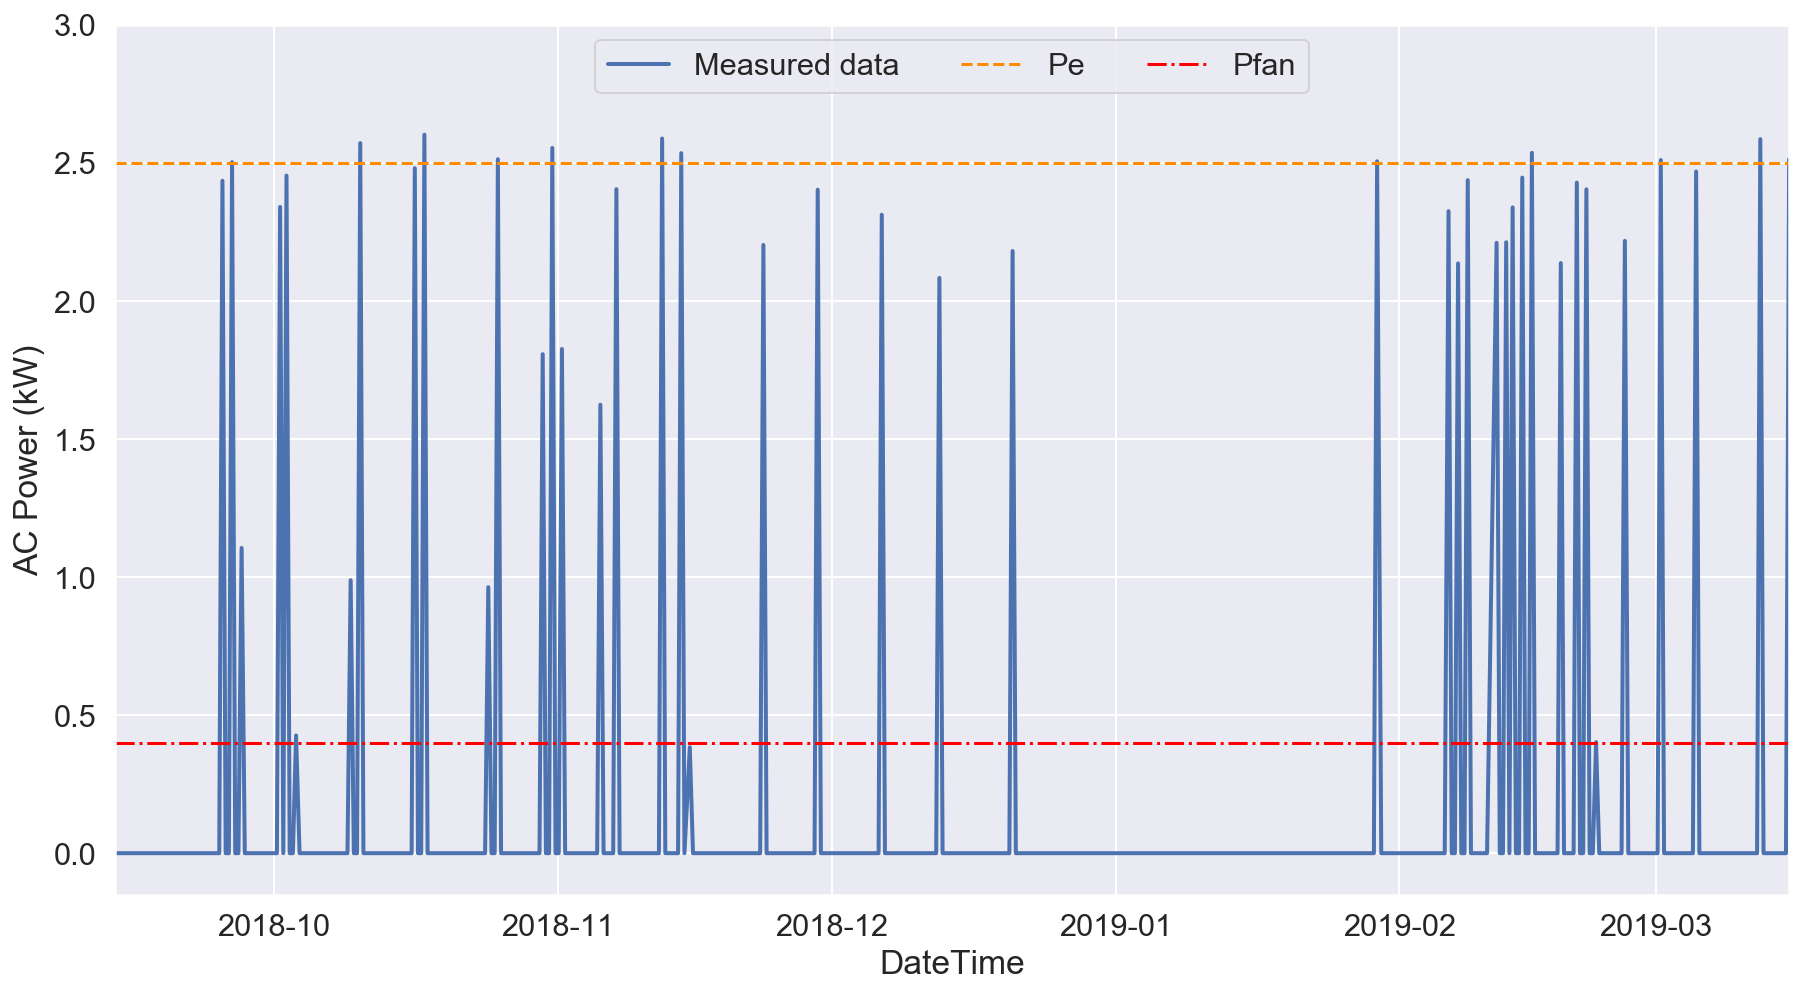

In [7]:
# AC electrical power consumption

x = df.loc[df['ac3_power'] > 1]
x_1 = x['ac3_power'].mode()
y = df.loc[(df['ac3_power'] > 0) & (df['ac3_power'] < 1)]
y_1 = y['ac3_power'].mode()
print('Pcool = {} kW'.format(7.58))
print('Pfan = {} kW'.format(round(y_1.values[0],1)))
print('COP = {:.3f}'.format(7.58/x_1.values[0]))

register_matplotlib_converters()
ax = df[['ac3_power']].loc[::500]
plt.figure(figsize=(15,8))
plt.plot(ax.index, ax['ac3_power'],linewidth=2,label='Measured data');
plt.axis([ax.index[25], ax.index[-30],-0.15, 3])
plt.xlabel('DateTime')
plt.ylabel('AC Power (kW)');
plt.axhline(2.5, color="darkorange", linestyle="--", linewidth=1.5,label='Pe');
plt.axhline(0.4, color="red", linestyle="-.", linewidth=1.5, label='Pfan');
plt.legend(loc='upper center',ncol=4)
plt.show();

<font size="3">
Extract parameters, $ 1-\frac{1}{RC} $, $ \frac{1}{RC} $, $-\frac{P^{cool}}{C}$, for the indoor zonal tmperature simulation using the linear regression
</font>

In [42]:
df_historical_fit = df[['ac3_temp', 'ambient_temp','ac3_comp']]
df_historical_fit['Target'] = df_historical_fit['ac3_temp'].shift(-1)
df_historical_fit = df_historical_fit.dropna()

X = df_historical_fit[['ac3_temp', 'ambient_temp','ac3_comp']]
y = df_historical_fit['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=0)
linreg = LinearRegression(normalize=True,fit_intercept=True).fit(X_train, y_train)
print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.4f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.4f}'
     .format(linreg.score(X_test, y_test)))
coeff_ac3 = pd.DataFrame(linreg.coef_, X.columns, columns=['Coefficient'])  
intercept_ac3 = linreg.intercept_

y_test.to_frame()
X_test['Predicted'] = linreg.predict(X_test.values)
result=pd.concat([X_test, y_test], axis='columns')

linear model coeff (w): [ 0.98566284  0.0033558  -0.16889002]
linear model intercept (b): 0.346
R-squared score (training): 0.9983
R-squared score (test): 0.9983


C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<font size="3">
<font color=darkblue>
$\delta$ is set to zero for AC compressor status simulation
</font>

<font size="3">
Evaluate the performance of linear regression model using:
<br.>
<br.>
$\mathrm{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_{i}-\widehat{y}_{i} )^2}$
<br.>
<br.>
$\mathrm{MBE} = \sum_{i=1}^N (y_{i}-\widehat{y}_{i})$
<br.>
<br.>
$\mathrm{R^2} = 1- \frac{\sum_{i=1}^N (y_{i}-\widehat{y}_{i})^2}{\sum_{i=1}^N (y_{i} - \bar{y})^2}$
<br.>
<br.>
where $N$ is the number of samples in the test set, $y_{i}$ and $\widehat{y}_{i}$ are measurement data and baseline results 
from deep learning model, respectively. $\bar{y}$ is the average of measured data. The lower values of $\mathrm{CV-RMSE}$ and 
$\mathrm{NMBE}$ indicate more accurate results. The higher value of $\mathrm{R^2}$ represents the higher correlation between 
the targeted and estimated outputs. 

Test set evaluation :
RMSE = 0.0776 °C
MBE  = 0.0001 °C
R-squared = 0.9983


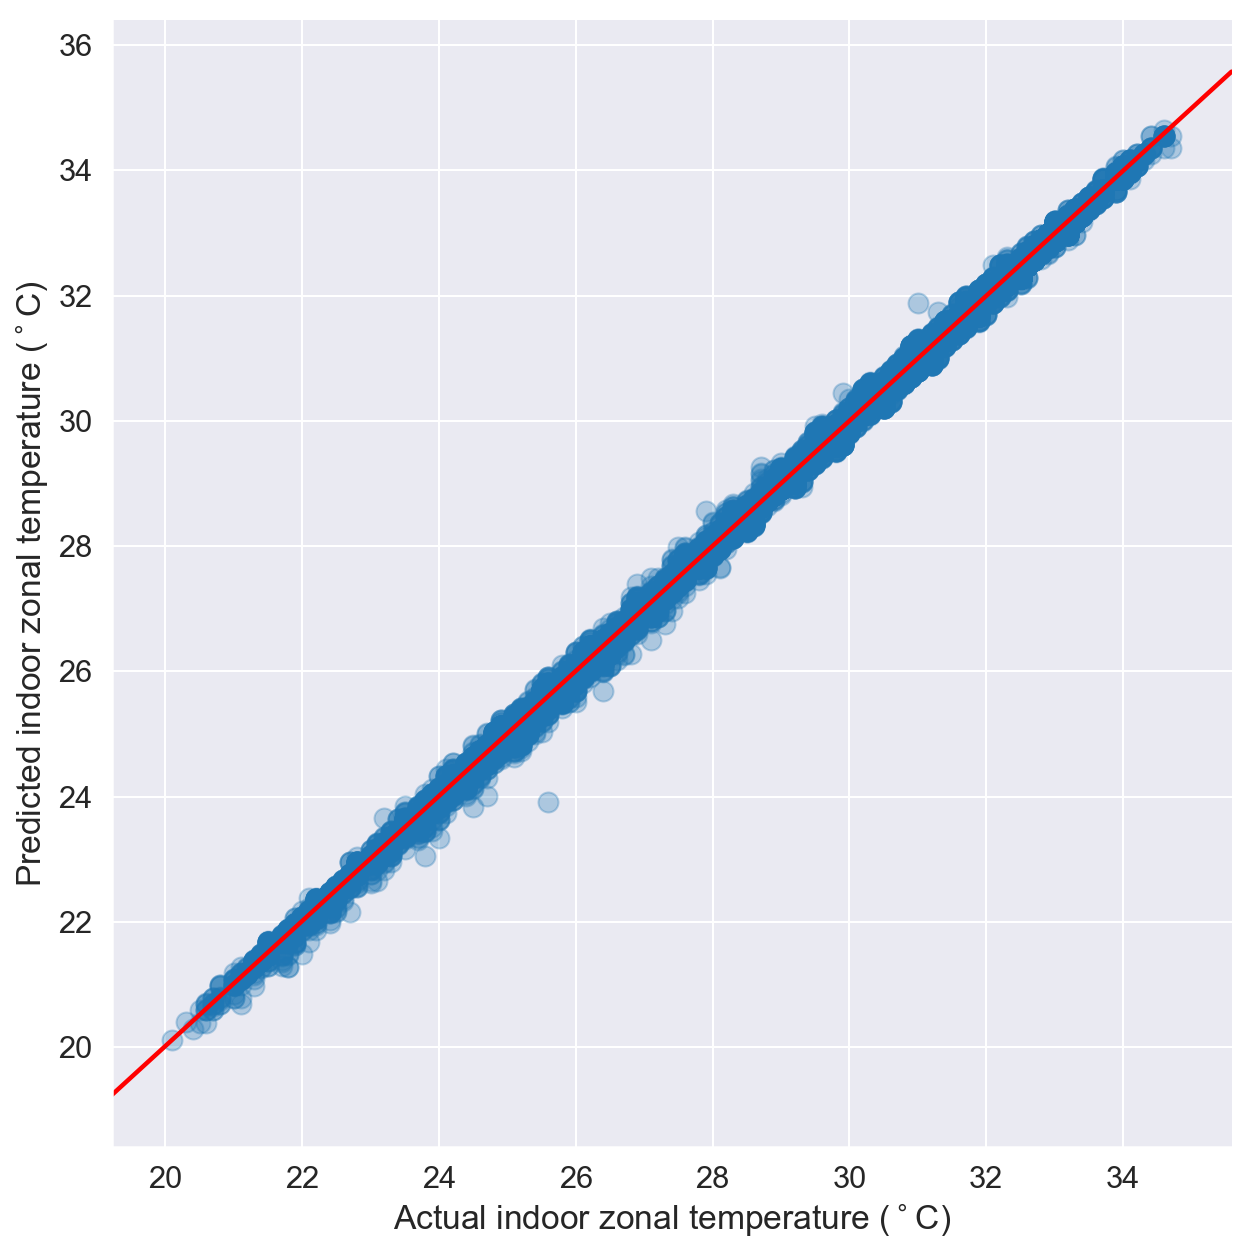

In [12]:
sns.set_style("darkgrid")
sns.lmplot(x='Target',
           y='Predicted',
           data=result,
           line_kws={'color': 'red'},
           height =3*3,
           scatter_kws={"s": 100,'alpha':.3,'color': '#1f77b4'});
plt.xlabel('Actual indoor zonal temperature ($^\circ$C)')
plt.ylabel('Predicted indoor zonal temperature ($^\circ$C)');

RMSE = sqrt(mean_squared_error(result['Target'], result['Predicted']))

MBE = (result['Target']-result['Predicted']).mean()

print('Test set evaluation :')
print('RMSE = {:.4f} °C'.format(RMSE)) 
print('MBE  = {:.4f} °C'.format(MBE))
print('R-squared = {:.4f}'.format(r2_score(result['Target'], result['Predicted'])))

# Define an environment using the AC model

In [28]:
class AC3():
    def __init__(self, pA, Tupper, Tlower):
        self.pA = pA  # Cooling ability
        AC3.Amb = baseline['Ambient_temp'][0]
        self.status = 0
        self.temp_set = 0.0
        self.T = 25.0
        self.w = 1
        self.pfan = 0.40
        self.n = 7.58/2.5  # Coefficient of Performance 
        self.delta = 0

        ###### comfort temperature
        
        self.Tupper = Tupper 
        self.Tlower = Tlower
        
        if self.Tupper < self.Tlower:
            a = self.Tupper
            b = self.Tlower
            self.Tupper = b
            self.Tlower = a
            
        elif self.Tlower == self.Tupper:
            self.Tupper = self.Tupper+1
            self.Tlower = self.Tlower-1
            
        else:
            self.Tupper = self.Tupper
            self.Tlower = self.Tlower
            
 
        AC3.Baseline = 0
        AC3.Terminal_state = 0


    def On(self):
        if self.status == 0:
            self.status = 1

    def Off(self):
        if self.status == 1:
            self.status = 0

    def getComfort(self):
        return self.Tupper, self.Tlower

    def getT(self):
        return self.T
    
    def getTempset(self):
        return self.temp_set

    def getAmb(self):
        return AC3.Amb
    
    def getOnOff(self):
        return self.status
    
    def getComp(self):
        return self.w

    def getP(self):
        return ((self.pA*self.w/self.n) + ((1-self.w)*self.pfan))*self.status

    def setT(self, temp):
        self.temp_set = temp

    def getbaseline(attribute, value_baseline):
        AC3.Baseline = value_baseline
        return AC3.Baseline
    
    def NextAmb(attribute, value_ambient):
        AC3.Amb = value_ambient
        return AC3.Amb
            
    def NextT(self):
        
        self.T = coeff_ac3['Coefficient'][0] * self.T + coeff_ac3['Coefficient'][1] * AC3.Amb + coeff_ac3['Coefficient'][2] * self.w + intercept_ac3
        
        if self.T > (self.temp_set + self.delta):
            self.w = 1*self.status
        elif self.T < (self.temp_set - self.delta):
            self.w = 0*self.status
        else:
            self.w = self.w*self.status
            

<font size="3">Read the estimated AC power baseline</font>

In [17]:
baseline_2017 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/estimated_baseline_2017.csv', index_col='DateTime',parse_dates=True)
baseline_2018 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/estimated_baseline_2018.csv', index_col='DateTime',parse_dates=True)
baseline = pd.concat([baseline_2017,baseline_2018])
baseline = baseline.reset_index()
baseline

,DateTime,Baseline,Ambient_temp,Episode
0,2017-01-01 07:00:00,0.0,24.5,1
1,2017-01-01 07:01:00,0.0,24.5,1
2,2017-01-01 07:02:00,0.0,24.5,1
3,2017-01-01 07:03:00,0.0,24.5,1
4,2017-01-01 07:04:00,0.0,24.5,1
...,...,...,...,...
1048570,2018-12-30 18:12:00,0.0,27.3,24
1048571,2018-12-30 18:13:00,0.0,27.3,24
1048572,2018-12-30 18:14:00,0.0,27.3,24
1048573,2018-12-30 18:15:00,0.0,27.3,24


# Environment simulation using the AC model and the estimated baseline

In [18]:
if __name__ == "__main__":
    
    env = AC3(7.58,27,23)

    num_episodes = 10000
    Tupper = np.array(env.getComfort())[0]
    Tlower = np.array(env.getComfort())[1]
    
    i = 0
    sumP = 0
    sumBaseline = 0
    
    Count_list, Tset_list, Amb_list, T_list, P_list, Baseline_list, EP_list  = [], [], [], [], [], [], []
    
    env.Off()
    env.setT(25.0)
    
    for i in range(num_episodes+1):
        
        if baseline['Baseline'][i] > 0:
            env.On()
            
            if i%15==0:
                env.setT(env.getT()+np.random.choice([0, 1, -1]))
        else:
            env.Off() 
            
        Baseline_list.append(env.getbaseline(baseline['Baseline'][i]))
        Tset_list.append(env.getTempset())
        T_list.append(env.getT())
        P_list.append(env.getP())
        EP_list.append(baseline['Episode'][i])
        env.NextAmb(baseline['Ambient_temp'][i])
        Amb_list.append(env.getAmb())
        Count_list.append(i)
        env.NextT() 
         

# Environment simulation results

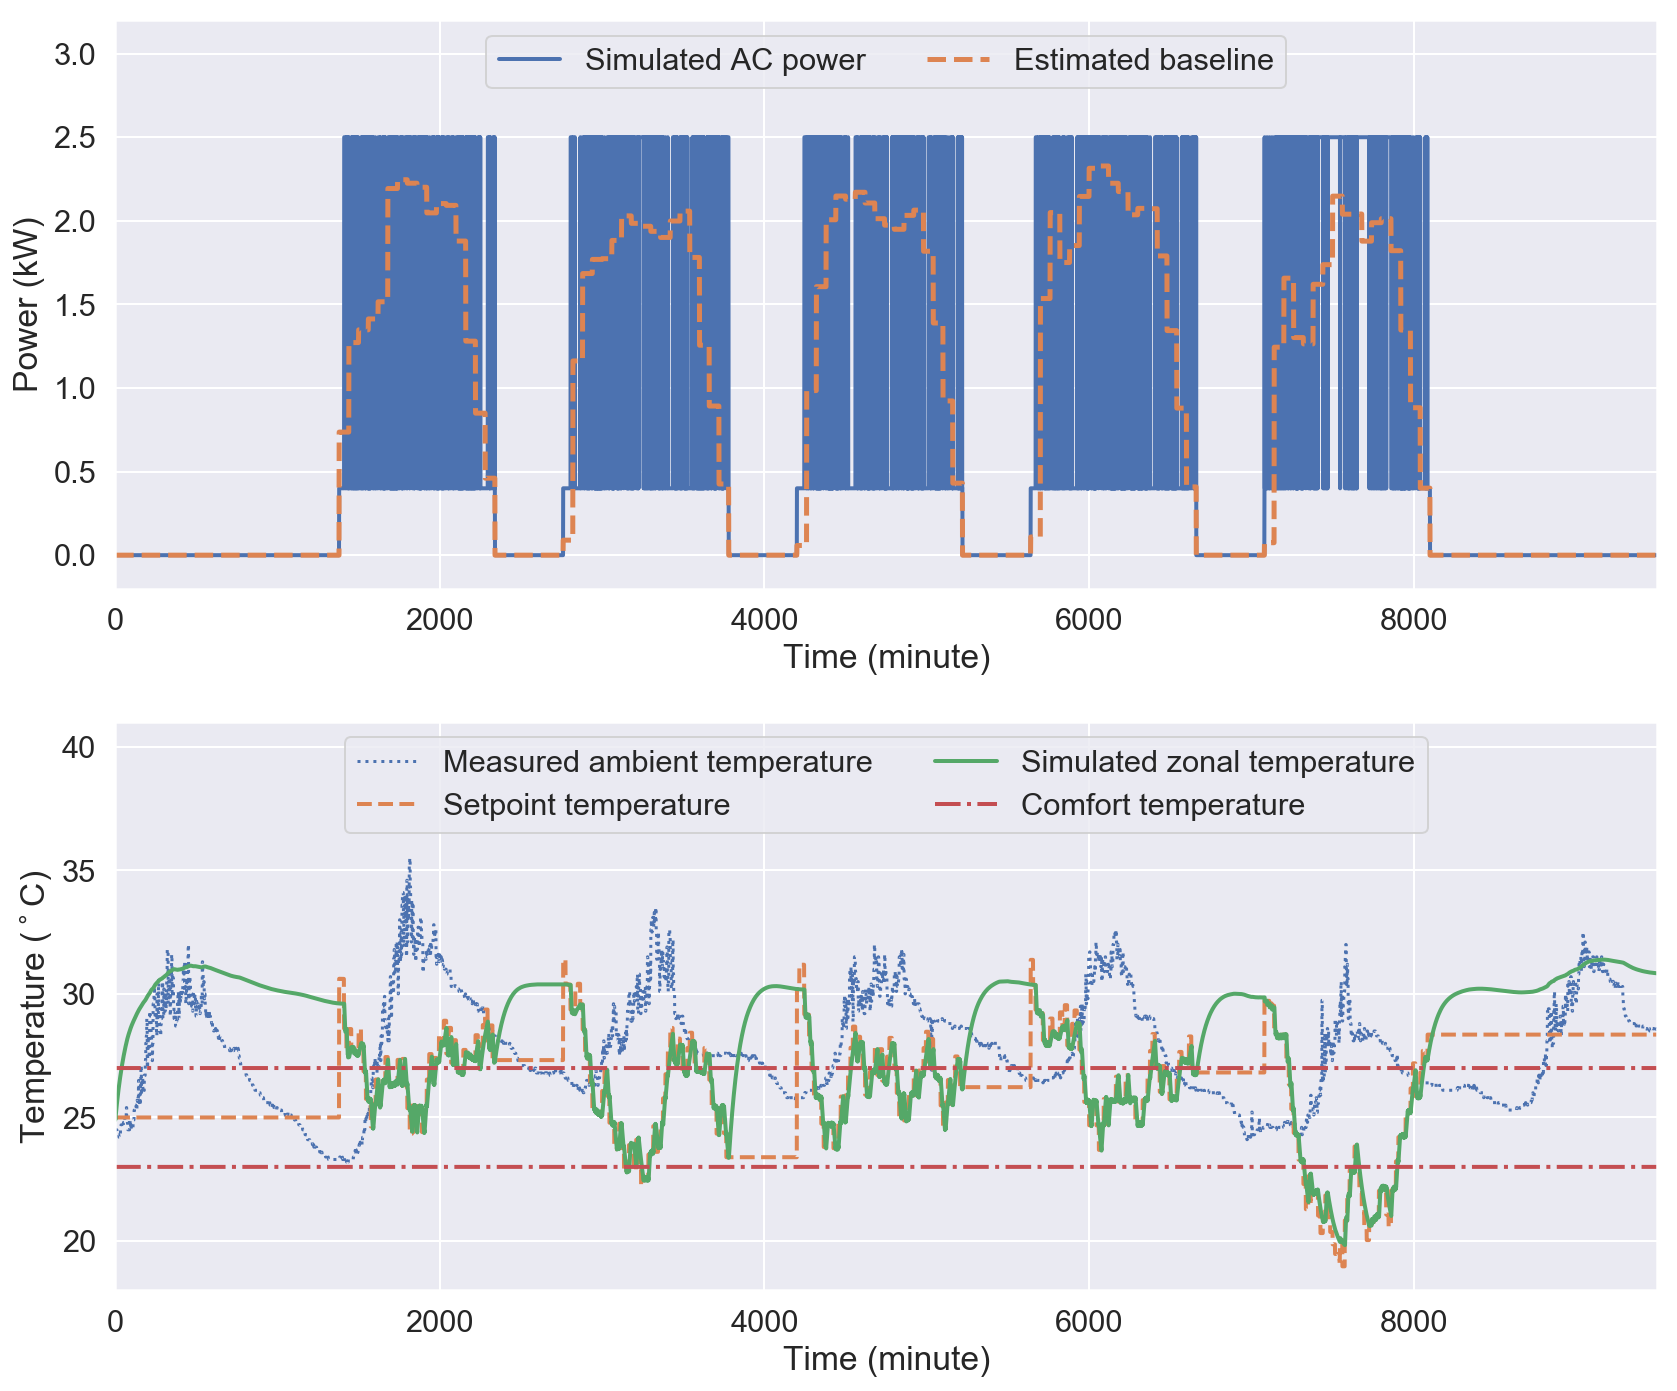

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))
ax1.plot(Count_list, P_list, linestyle='-',label='Simulated AC power',linewidth=2)
ax1.plot(Count_list, Baseline_list, linestyle='--',label='Estimated baseline',linewidth=2.5)
ax1.set_xlabel('Time (minute)')
ax1.axis([0, 9500, -0.2,3.2])
ax1.set_ylabel('Power (kW)')
ax1.legend(loc='upper center',ncol=2)
ax1.grid(True)

ax2.plot(Count_list, Amb_list, linestyle=':',label='Measured ambient temperature',linewidth=1.5)
ax2.plot(Count_list, Tset_list, linestyle='--',label='Setpoint temperature',linewidth=2)
ax2.plot(Count_list, T_list, linestyle='-',label='Simulated zonal temperature',linewidth=2)
ax2.plot(Count_list, np.repeat(env.Tlower, len(Count_list)), linestyle='-.',label='Comfort temperature',linewidth=2)
ax2.plot(Count_list, np.repeat(env.Tupper, len(Count_list)), linestyle='-.',linewidth=2, color='C3')
ax2.set_xlabel('Time (minute)')
ax2.axis([0, 9500, 18, 41])
ax2.set_ylabel('Temperature ($^\circ$C)')
ax2.legend(loc='upper center',ncol=2)
ax2.grid(True)

plt.tight_layout()

# Enivronment verification

<font size="3">Read measured data for verification the designed environment</font>

In [20]:
df_verify = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/environment_verification.csv')
df_verify['DateTime'] = df_verify['DateTime'].str.slice(stop=19)
df_verify['DateTime'] = pd.to_datetime(df_verify['DateTime'],dayfirst=True)
df_verify.index = df_verify['DateTime']
df_verify = df_verify.drop(['DateTime'],axis=1)
df_verify

,Measured compressor status,Measured On/Off status,Measured setpoint temperature,Measured ambient temperature,Measured power consumption,Measured zonal temperature
DateTime,,,,,,
2018-09-04 09:59:00,0,1,24,29.3,0.33336,24.7
2018-09-04 10:00:00,0,1,24,29.4,0.38304,24.8
2018-09-04 10:01:00,1,1,24,29.4,2.16660,24.8
2018-09-04 10:02:00,1,1,24,29.4,2.35992,24.8
2018-09-04 10:03:00,1,1,24,29.3,2.33826,24.7
...,...,...,...,...,...,...
2019-01-30 14:11:00,1,1,25,32.8,2.19828,25.4
2019-01-30 14:12:00,0,1,25,33.4,1.96248,25.1
2019-01-30 14:12:00,0,1,25,33.4,1.96248,25.2


<font size="3">
Run environment again to generate simulation data e.g. AC power consumption, indoor zonal temperature, etc. 
</font>

In [21]:
if __name__ == "__main__":
    
    env = AC3(7.58,27,23)

    num_episodes = len(df_verify)-1

    Tupper = np.array(env.getComfort())[0]
    Tlower = np.array(env.getComfort())[1]

    i = 0
    
    Count_list_verify, Amb_list_verify = [], []
    Tset_list_verify = []
    T_list_verify = []
    P_list_verify = []
    Comp_status_list_verify = []
    On_off_list_verify = []
    
    
    env.Off()
    env.setT(25.0)
    
    
    while i < num_episodes:
        
        env.setT(df_verify['Measured setpoint temperature'][i])
        
        if df_verify['Measured power consumption'][i] > 0:
            env.On()
            
        else:
            env.Off() 
        
        Tset_list_verify.append(env.getTempset())
        T_list_verify.append(env.getT())
        P_list_verify.append(env.getP())
        Count_list_verify.append(i)
        On_off_list_verify.append(env.getOnOff())
        Comp_status_list_verify.append(env.getComp())
        i = i+1
        env.NextAmb(df_verify['Measured ambient temperature'][i])
        Amb_list_verify.append(env.getAmb())
        env.NextT() 
            

<font size="3">
Build new dataframe to collect simulated data and join simulated data with measured data
</font>

In [22]:
df3 = pd.DataFrame(data={'Simulated power consumption': P_list_verify, 'Simulated zonal temperature': T_list_verify, 'Simulated compressor status': Comp_status_list_verify, 'Simulated On/Off status':On_off_list_verify})
df2 = df_verify
df2 = df2.reset_index()
df2 = df2[:-1]
verify = pd.concat([df2, df3], axis=1, join='inner')
verify.index = verify['DateTime']
verify = verify.drop('DateTime',axis=1)
verify

,Measured compressor status,Measured On/Off status,Measured setpoint temperature,Measured ambient temperature,Measured power consumption,Measured zonal temperature,Simulated power consumption,Simulated zonal temperature,Simulated compressor status,Simulated On/Off status
DateTime,,,,,,,,,,
2018-09-04 09:59:00,0,1,24,29.3,0.33336,24.7,2.5,25.000000,1,1
2018-09-04 10:00:00,0,1,24,29.4,0.38304,24.8,2.5,24.917056,1,1
2018-09-04 10:01:00,1,1,24,29.4,2.16660,24.8,2.5,24.835301,1,1
2018-09-04 10:02:00,1,1,24,29.4,2.35992,24.8,2.5,24.754718,1,1
2018-09-04 10:03:00,1,1,24,29.3,2.33826,24.7,2.5,24.674954,1,1
...,...,...,...,...,...,...,...,...,...,...
2019-01-30 14:10:00,1,1,25,32.8,2.20404,25.4,2.5,27.865179,1,1
2019-01-30 14:11:00,1,1,25,32.8,2.19828,25.4,2.5,27.752565,1,1
2019-01-30 14:12:00,0,1,25,33.4,1.96248,25.1,2.5,27.643580,1,1


<font size="3">
Example plots of measured data and simulated data
</font>

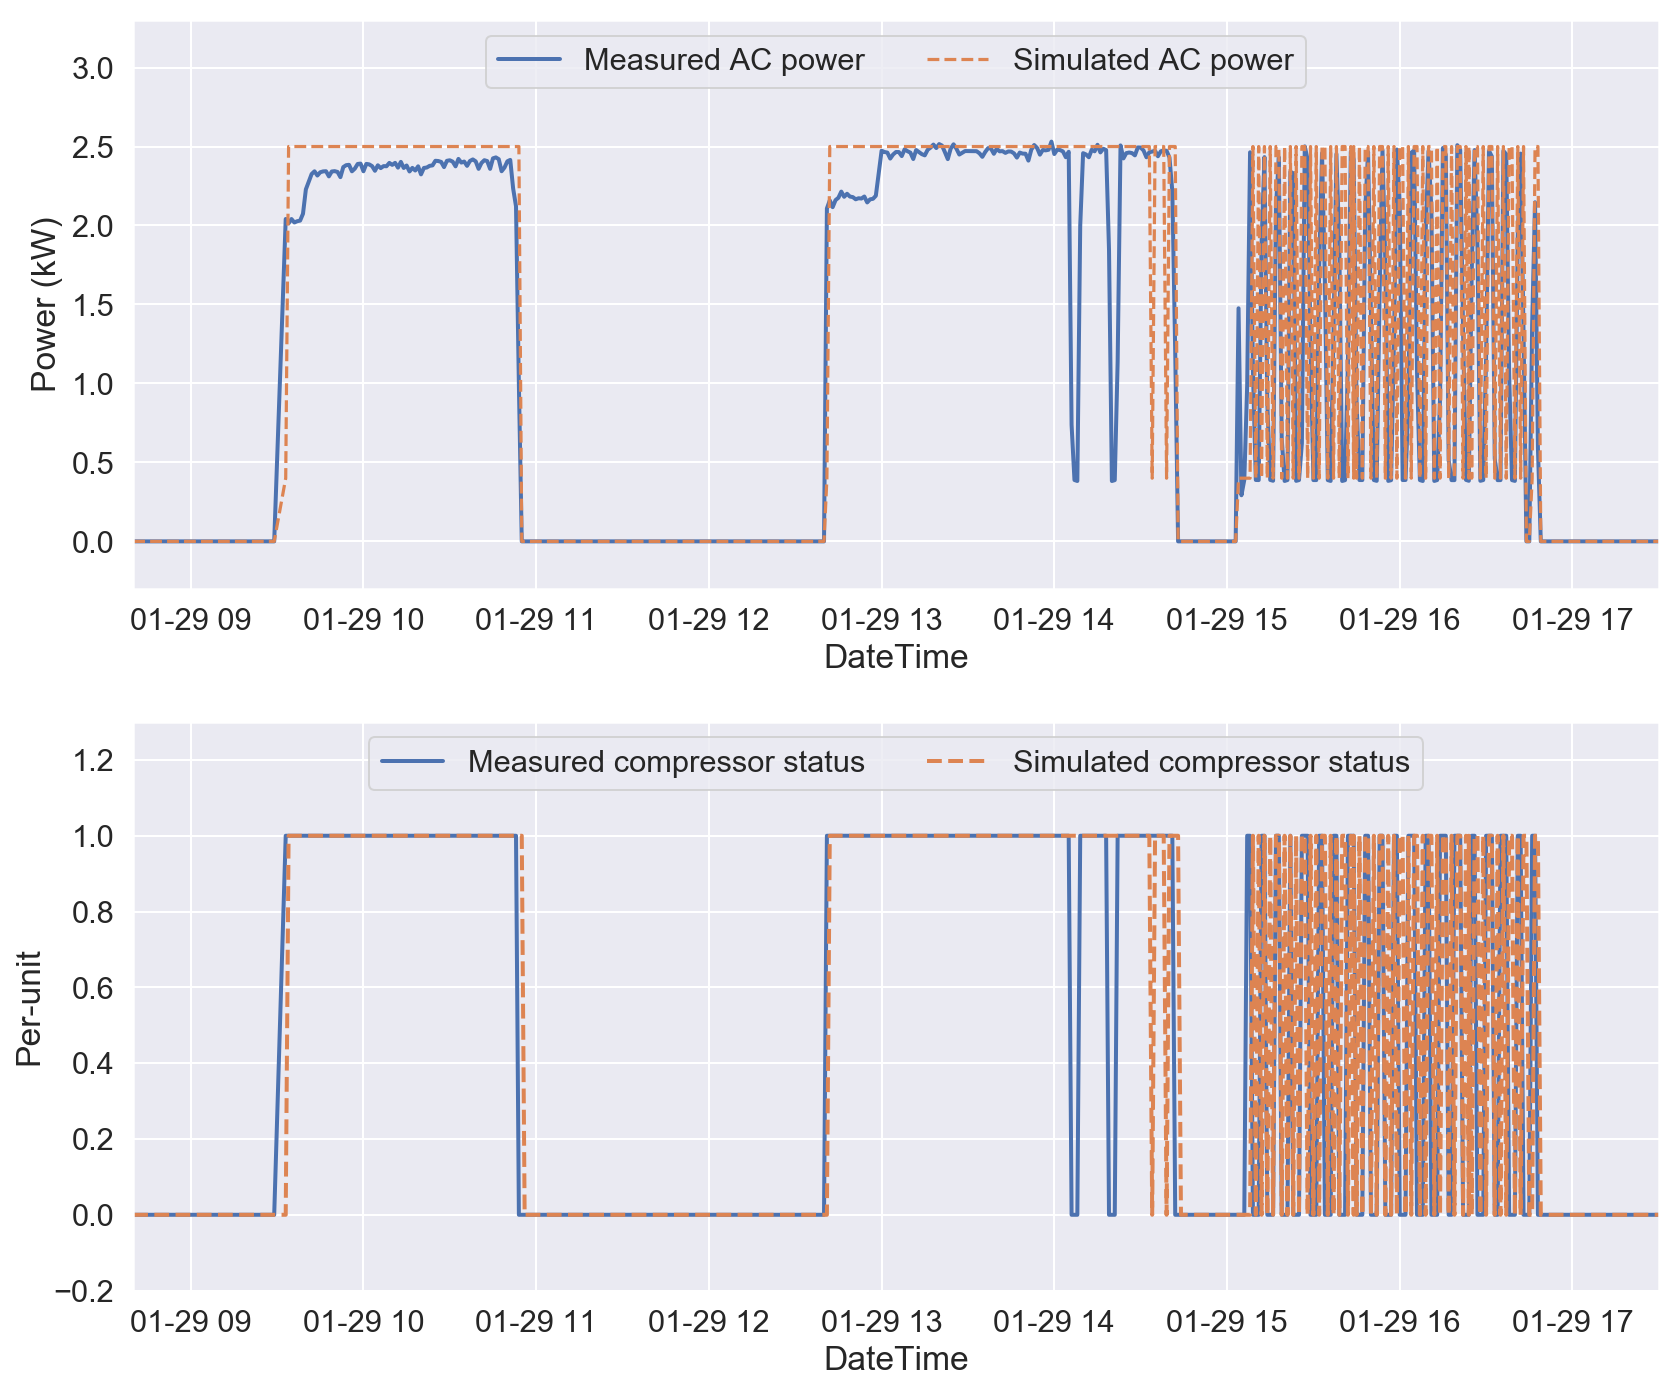

In [23]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10))

verify_power = verify[['Measured power consumption', 'Simulated power consumption']].loc['2019-01-29 08:40:00':'2019-01-29 17:30:00']
ax1.plot(verify_power.index, verify_power['Measured power consumption'],linewidth= 2,label='Measured AC power')
ax1.plot(verify_power.index, verify_power['Simulated power consumption'],linewidth= 1.6 ,linestyle='--',label='Simulated AC power')
ax1.axis(['2019-01-29 08:40:00','2019-01-29 17:30:00', -0.3, 3.3])
ax1.set_ylabel('Power (kW)')
ax1.set_xlabel('DateTime')
ax1.grid(True)
ax1.legend()
ax1.legend(loc='upper center',ncol=2);

verify_comp = verify[['Measured compressor status', 'Simulated compressor status']].loc['2019-01-29 08:40:00':'2019-01-29 17:30:00']
ax2.plot(verify_comp.index, verify_comp['Measured compressor status'],linewidth= 2, label='Measured compressor status')
ax2.plot(verify_comp.index, verify_comp['Simulated compressor status'],linewidth= 2, label='Simulated compressor status',linestyle='--')
ax2.axis(['2019-01-29 08:40:00','2019-01-29 17:30:00',-0.2, 1.3])
ax2.set_ylabel('Per-unit')
ax2.set_xlabel('DateTime')
ax2.grid(True)
ax2.legend()
ax2.legend(loc='upper center',ncol=2)

plt.tight_layout()
plt.show()

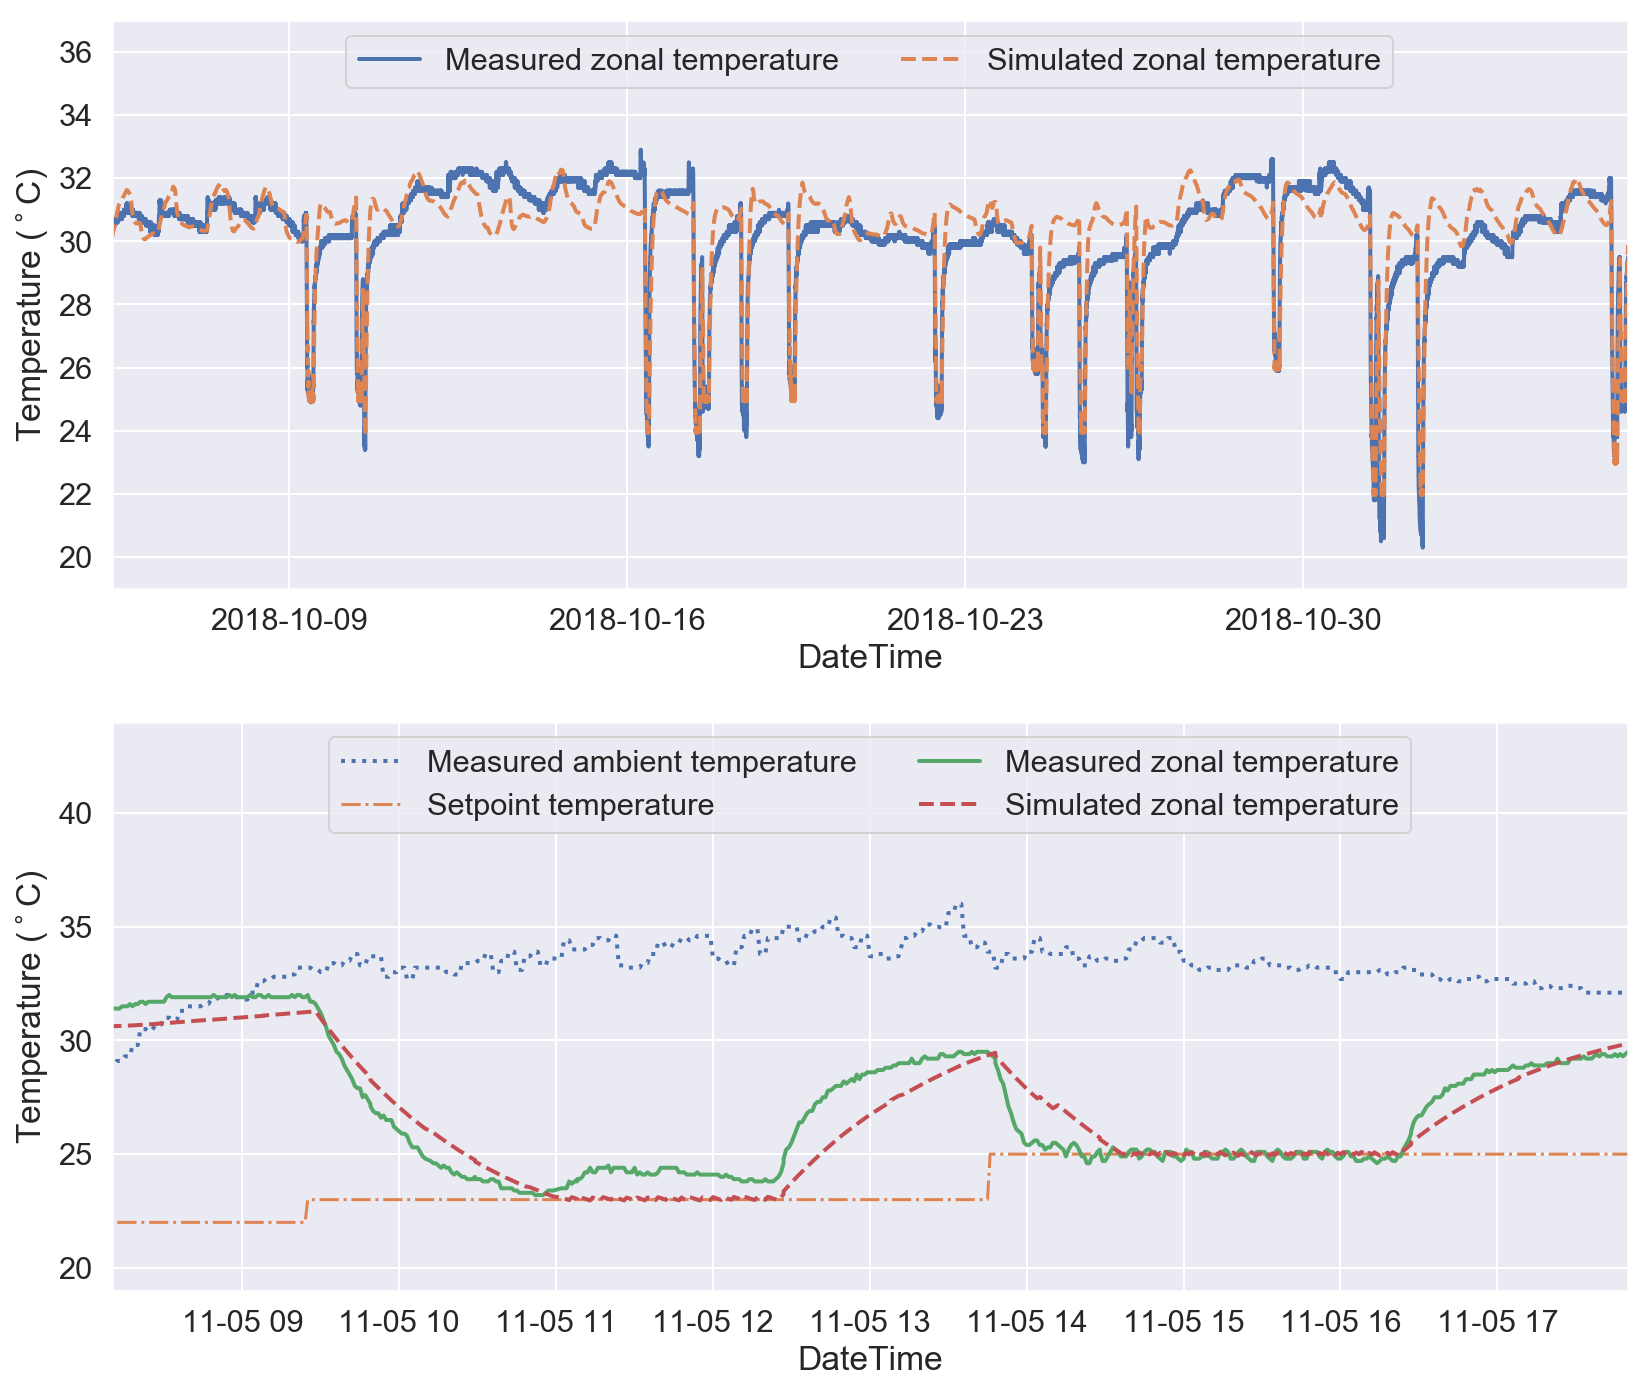

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12, 10))

verify_temp = verify[['Measured zonal temperature','Simulated zonal temperature','Measured setpoint temperature','Measured ambient temperature']].loc['2018-10-05 08:00:00':'2018-11-05 17:50:00']
ax1.plot(verify_temp.index, verify_temp['Measured zonal temperature'],linewidth= 2, label='Measured zonal temperature')
ax1.plot(verify_temp.index, verify_temp['Simulated zonal temperature'],linewidth= 2, label='Simulated zonal temperature',linestyle='--')
ax1.axis(['2018-10-05 08:00:00', '2018-11-05 17:50:00',19, 37])
ax1.set_ylabel('Temperature ($^\circ$C)')
ax1.set_xlabel('DateTime')
ax1.grid(True)
ax1.legend()
ax1.legend(loc='upper center',ncol=2)

verify_all_temp = verify[['Measured zonal temperature','Simulated zonal temperature','Measured setpoint temperature','Measured ambient temperature']].loc['2018-11-05 08:00:00':'2018-11-05 17:50:00']
ax2.plot(verify_all_temp.index, verify_all_temp['Measured ambient temperature'],linewidth= 2,linestyle=':', label='Measured ambient temperature')
ax2.plot(verify_all_temp.index, verify_all_temp['Measured setpoint temperature'],linewidth= 1.5,linestyle='-.', label='Setpoint temperature')
ax2.plot(verify_all_temp.index, verify_all_temp['Measured zonal temperature'],linewidth= 2, label='Measured zonal temperature',linestyle='-')
ax2.plot(verify_all_temp.index, verify_all_temp['Simulated zonal temperature'],linewidth= 2, label='Simulated zonal temperature',linestyle='--')
ax2.axis(['2018-11-05 08:10:00', '2018-11-05 17:50:00',19, 44])
ax2.set_ylabel('Temperature ($^\circ$C)')
ax2.set_xlabel('DateTime')
ax2.grid(True)
ax2.legend()
ax2.legend(loc='upper center',ncol=2)

plt.tight_layout()
plt.show()

<font size="3">
Evaluate the performance of environment using $\mathrm{RMSE}$, $\mathrm{MBE}$ and $\mathrm{R^2}$
</font>

In [25]:
print('Environment evaluation:')
print('*'*30)
print('AC power consumption evaluation:')
RMSE = sqrt(mean_squared_error(verify['Measured power consumption'], verify['Simulated power consumption']))
print('RMSE = {:.4f} kW'.format(RMSE))
print('MBE = {:.4f} kW'.format((verify['Measured power consumption']-verify['Simulated power consumption']).mean()))
print('R-squared = {:.4f}'.format(r2_score(verify['Measured power consumption'], verify['Simulated power consumption'])))
print('*'*30)
print('Indoor zonal temperature evaluation:')
RMSE = sqrt(mean_squared_error(verify['Measured zonal temperature'], verify['Simulated zonal temperature']))
print('RMSE = {:.4f} °C'.format(RMSE))
print('MBE = {:.4f} °C'.format((verify['Measured zonal temperature']-verify['Simulated zonal temperature']).mean()))
print('R-squared = {:.4f}'.format(r2_score(verify['Measured zonal temperature'], verify['Simulated zonal temperature'])))

Environment evaluation:
******************************
AC power consumption evaluation:
RMSE = 0.2587 kW
MBE = -0.0027 kW
R-squared = 0.6919
******************************
Indoor zonal temperature evaluation:
RMSE = 0.9831 °C
MBE = -0.1202 °C
R-squared = 0.6963


<font size="3">
Verify the measured data and simulated data using the Pearson's correlation coefficient $(r)$ and visualize by heatmap
</font>

[Correlation coefficient interpretation guideline](http://image.slidesharecdn.com/guidelineforinterpretingcorrelationcoefficient-140705051726-phpapp02/95/guideline-for-interpreting-correlation-coefficient-3-638.jpg?cb=1404537512)
                

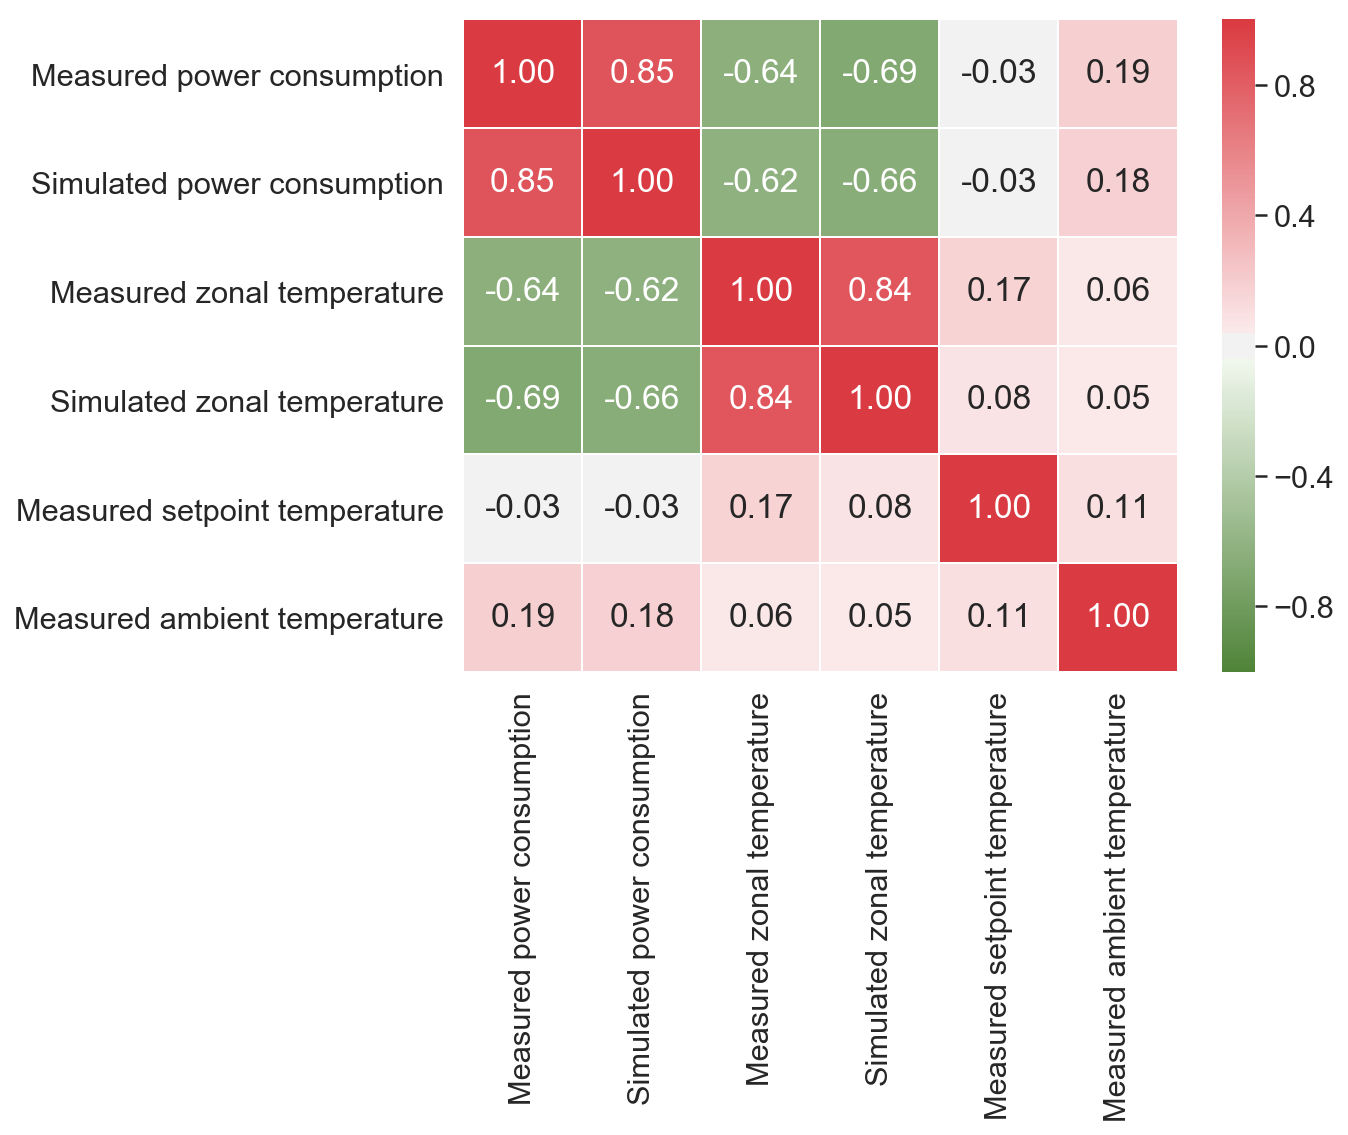

In [27]:
verify_heatmap = verify[['Measured power consumption','Simulated power consumption','Measured zonal temperature','Simulated zonal temperature','Measured setpoint temperature','Measured ambient temperature']]
cmap = sns.diverging_palette(h_neg=120, h_pos=11, as_cmap=True)
plt.figure(figsize=(8,6))
sns.heatmap(verify_heatmap.corr(method='pearson'),annot=True,linewidths=.5, vmin=-1,vmax=1,fmt='.2f', cmap=cmap);